In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import h5py
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from hisscube import MLProcessor as mlp
from hisscube import VisualizationProcessor as vp
from hisscube import Photometry as photUtils

h5_path = "../results/SDSS_cube_parallel.h5"
cube_utils = photUtils.Photometry("../config/SDSS_Bands",
                                   "../config/ccd_gain.tsv",
                                   "../config/ccd_dark_variance.tsv")



<IPython.core.display.Javascript object>


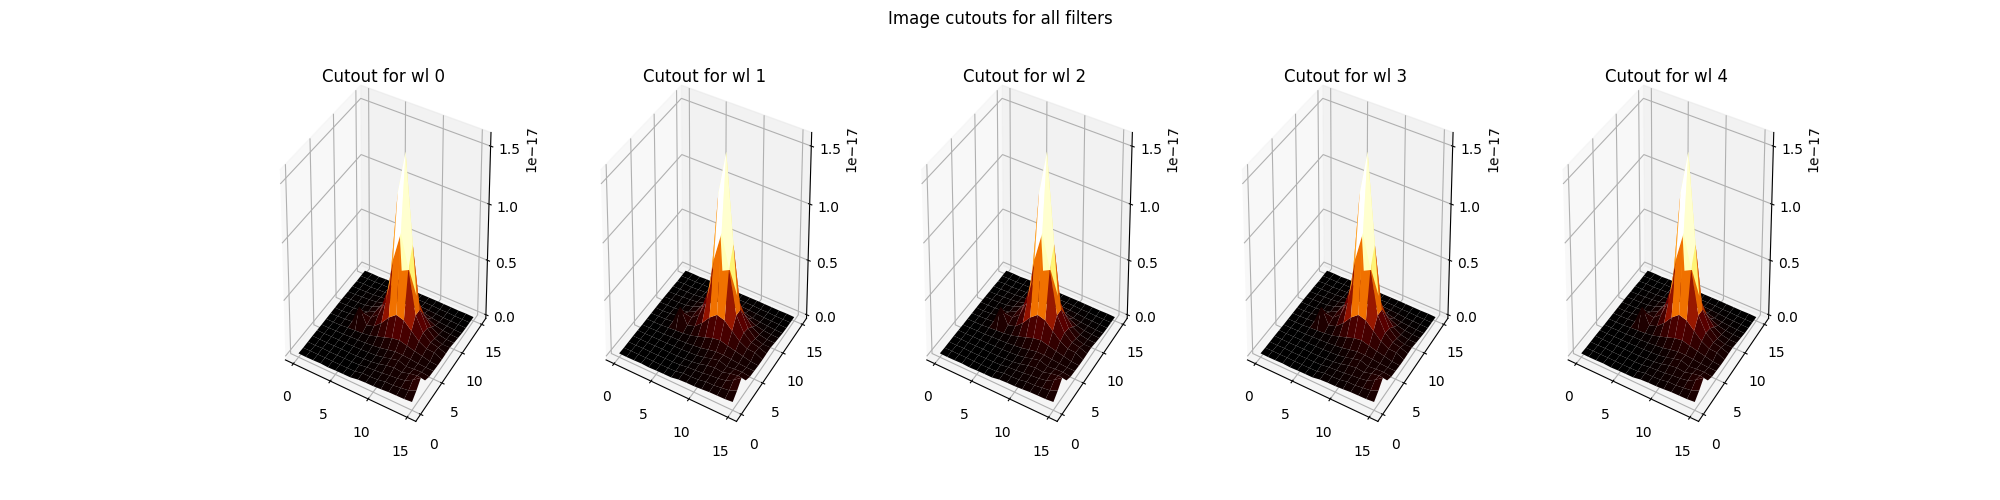

<IPython.core.display.Javascript object>


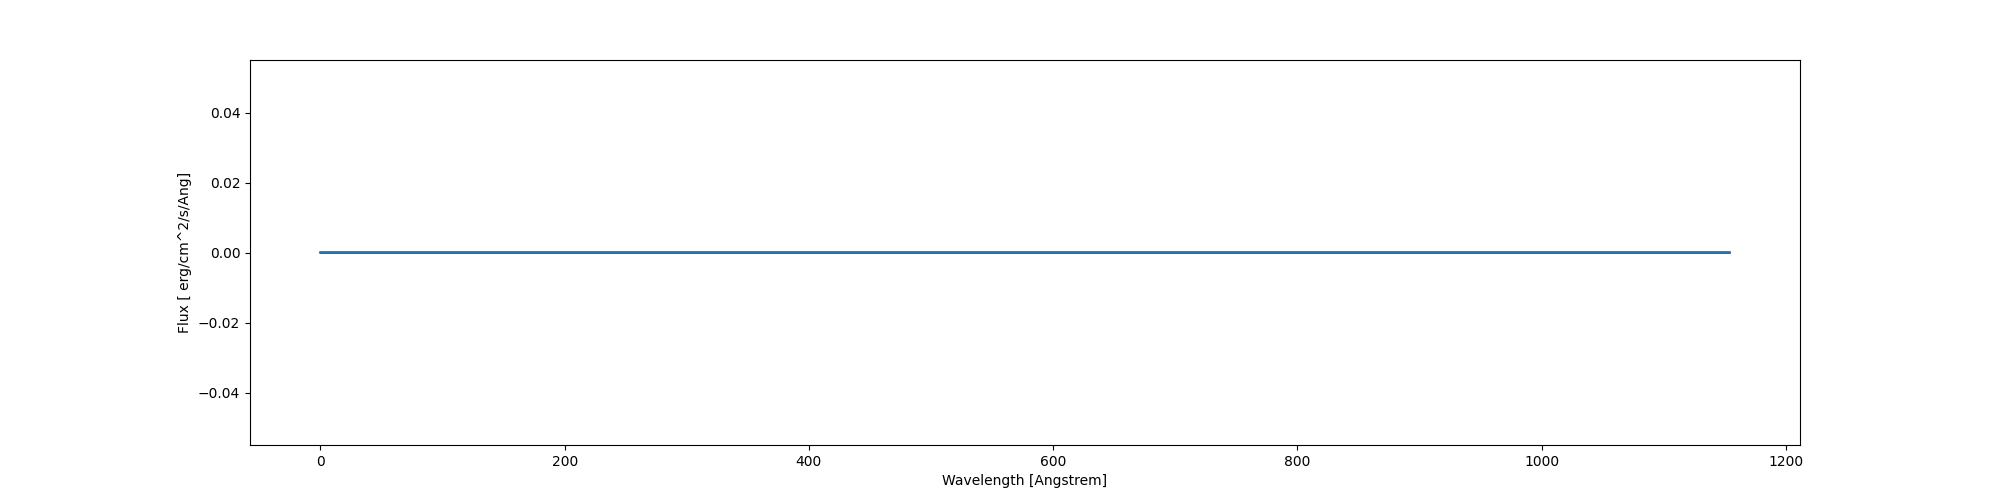

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [5]:
RES = 2
reload(mlp)
cutouts, specs = None, None
%matplotlib notebook
def plot_cutout(cutouts, fig, nrows, ncols):
    for idx, cutout in enumerate(cutouts):
        ax = fig.add_subplot(nrows,ncols,idx+1, projection='3d')
        x = range(0,cutout.shape[0])
        y = range(0,cutout.shape[1])
        xv, yv = np.meshgrid(x,y)
        pixels = cutout_1[0,:,:,0]
        dem3d=ax.plot_surface(xv,yv,pixels,cmap='afmhot', linewidth=0)
        ax.set_title('Cutout for wl %d' % idx)
        
        

h5_file = h5py.File(h5_path, 'r')
h5p = mlp.MLProcessor(h5_file)

cutout, spec = h5p.get_spectrum_3d_cube(RES)
no_targets = h5p.get_no_targets()
cutout_1, spec_1 = cutout[0], spec[0]

fig = plt.figure(figsize=(20,5))
fig.suptitle('Image cutouts for all filters')
plot_cutout(cutout_1, fig, 1, 5)
fig2 = plt.figure(figsize=(20,5))
wl = range(0, spec_1.shape[0])
flux = spec_1[:,0]
flux_sigma = spec_1[:,1]
ax = plt.axes(xlabel="Wavelength [Angstrem]", ylabel="Flux [ erg/cm^2/s/Ang]")
ax.plot(wl, flux, color="blue")
ax.fill_between(wl, 
                flux - flux_sigma, 
                flux + flux_sigma, 
                color="orange")
ax.plot(wl, flux)

plt.show()
print(spec_1)
    


    
    

In [3]:
h5_file.close()

<IPython.core.display.Javascript object>


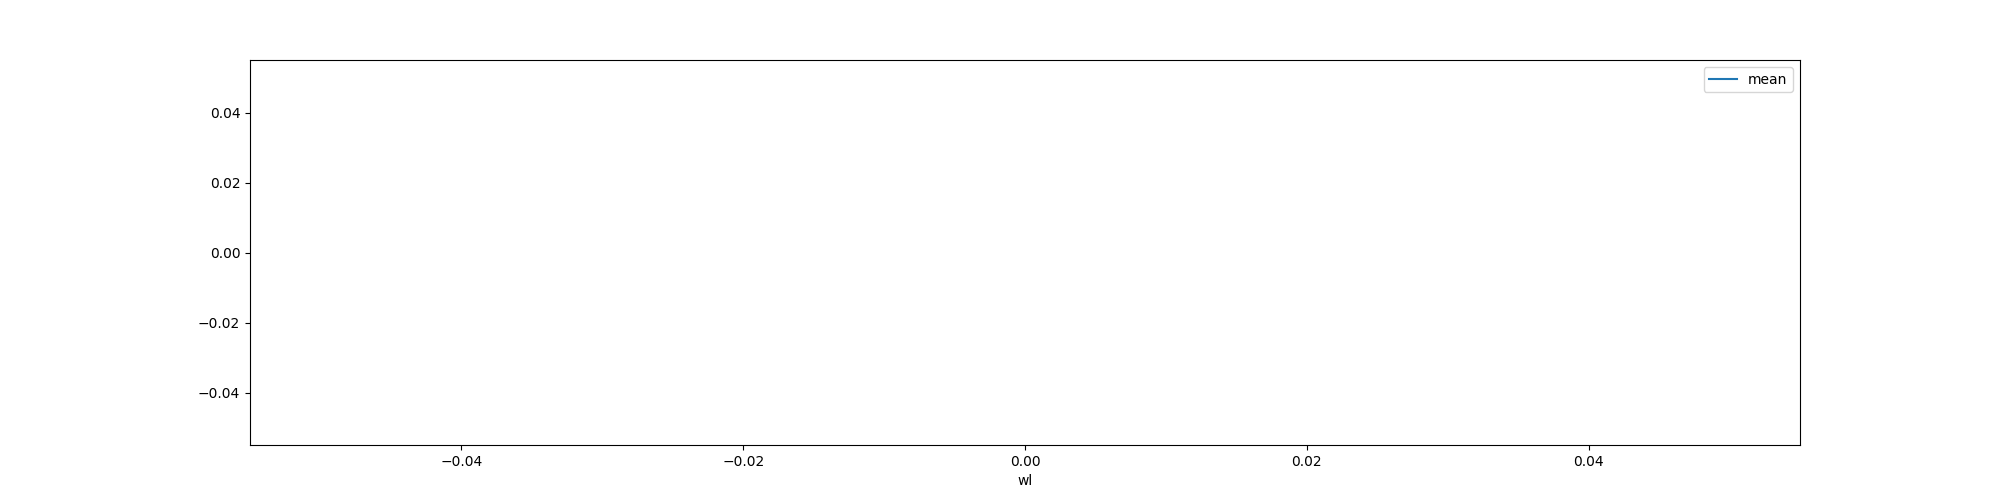

<IPython.core.display.Javascript object>


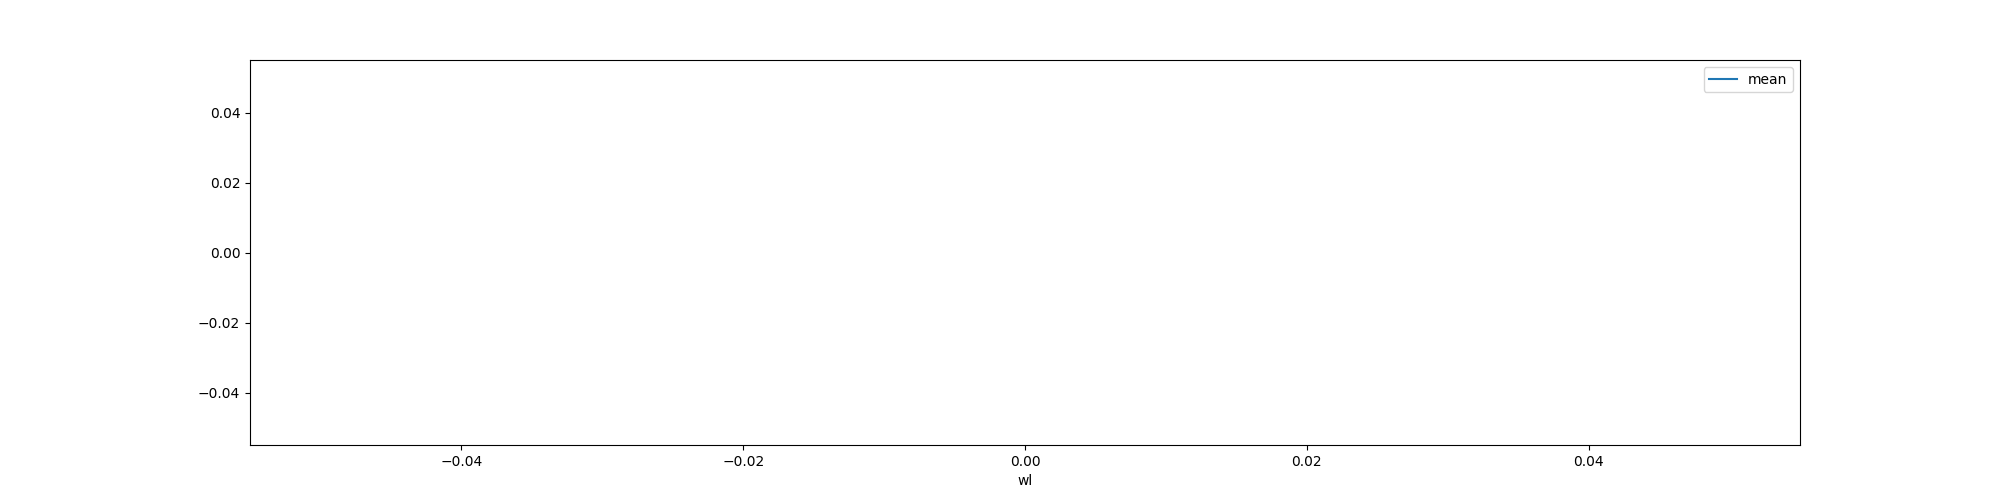

              heal_id         ra       dec     time      wl          mean  \
0       1557517971485  46.560471 -0.344359  51871.0     0.0  0.000000e+00   
1       1557517971485  46.560471 -0.344359  51871.0     0.0  0.000000e+00   
2       1557517971485  46.560471 -0.344359  51871.0     0.0  0.000000e+00   
3       1557517971485  46.560471 -0.344359  51871.0     0.0  0.000000e+00   
4       1557517971485  46.560471 -0.344359  51871.0     0.0  0.000000e+00   
...               ...        ...       ...      ...     ...           ...   
270236  1557517973610  46.560131 -0.340498  52173.0  3551.0  3.938703e-19   
270237  1557517973610  46.560131 -0.340058  52173.0  3551.0  2.181110e-19   
270238  1557517973610  46.560131 -0.339618  52173.0  3551.0  1.380664e-19   
270239  1557517973610  46.560131 -0.339177  52173.0  3551.0 -2.018056e-19   
270240  1557517973610  46.560131 -0.338737  52173.0  3551.0  1.272667e-19   

               sigma    spec_ra  spec_dec                      fits_name  \

ra   dec  time    wl  mean  \
heal_id       fits_name                                                     
1557517971485 b'frame-g-001894-3-0103.fits'  2048  2048  2048  2048  2048   
              b'frame-g-002579-3-0071.fits'  2048  2048  2048  2048  2048   
              b'frame-g-002591-3-0039.fits'  2048  2048  2048  2048  2048   
              b'frame-g-002591-3-0040.fits'  2048  2048  2048  2048  2048   
              b'frame-g-002709-3-0179.fits'  2048  2048  2048  2048  2048   
...                                           ...   ...   ...   ...   ...   
1557517973610 b'frame-z-005042-3-0192.fits'   768   768   768   768   768   
              b'frame-z-007183-3-0266.fits'   768   768   768   768   768   
              b'spec-0411-51817-0119.fits'   1155  1155  1155  1155  1155   
              b'spec-0411-51873-0101.fits'   1155  1155  1155  1155  1155   
              b'spec-0411-51914-0103.fits'   1155  1155  1155  1155  1155   

                                             sigma  spec_ra  spec_dec  \
heal_id       fits_name                                                 
1557517971485 b'frame-g-001894-3-0103.fits'   2048     2048      2048   
              b'frame-g-002579-3-0071.fits'   2048     2048      2048   
              b'frame-g-002591-3-0039.fits'   2048     2048      2048   
              b'frame-g-002591-3-0040.fits'   2048     2048      2048   
              b'frame-g-002709-3-0179.fits'   2048     2048      2048   
...                                            ...      ...       ...   
1557517973610 b'frame-z-005042-3-0192.fits'    768      768       768   
              b'frame-z-007183-3-0266.fits'    768      768       768   
              b'spec-0411-51817-0119.fits'    1155     1155      1155   
              b'spec-0411-51873-0101.fits'    1155     1155      1155   
              b'spec-0411-51914-0103.fits'    1155     1155      1155   

                                             spec_fits_name  
heal_id       fits_name                                      
1557517971485 b'frame-g-001894-3-0103.fits'            2048  
              b'frame-g-002579-3-0071.fits'            2048  
              b'frame-g-002591-3-0039.fits'            2048  
              b'frame-g-002591-3-0040.fits'            2048  
              b'frame-g-002709-3-0179.fits'            2048  
...                                                     ...  
1557517973610 b'frame-z-005042-3-0192.fits'             768  
              b'frame-z-007183-3-0266.fits'             768  
              b'spec-0411-51817-0119.fits'             1155  
              b'spec-0411-51873-0101.fits'             1155  
              b'spec-0411-51914-0103.fits'             1155  

[193 rows x 9 columns]

In [7]:
import pandas as pd
reload(vp)

def plot_spec(spec_0):
    wl = spec_0["wl"]
    flux = spec_0["mean"]
    flux_sigma = spec_0["sigma"]
    ax = spec_0.plot(x="wl", y="mean", figsize=(20,5))
    ax.fill_between(wl, 
                    flux - flux_sigma, 
                    flux + flux_sigma, 
                    color="orange")

h5v = vp.VisualizationProcessor(h5_file)
cube_4d_table = h5v.read_spectral_cube_table(RES)
pd_cube = pd.DataFrame.from_records(cube_4d_table)
condition = pd_cube['fits_name'] == b'spec-0412-51871-0308.fits'
condition_1 = pd_cube['fits_name'] ==b'spec-0411-51817-0119.fits'
spec_0 = pd_cube[condition].filter(["wl", "mean", "sigma"])
spec_1 = pd_cube[condition_1].filter(["wl", "mean", "sigma"])
plot_spec(spec_0)
plot_spec(spec_1)
print(pd_cube)
pd_cube.groupby(['heal_id','fits_name']).count()
#h5_file.close()


In [160]:
reload(mlp)
cutouts = np.reshape(cutout, (no_targets,-1))
specs = np.reshape(cutout, (no_targets,-1))


cutout_distance = h5p.target_distance(cutouts[0], cutout[1])
spec_distance = h5p.target_distance(spec[0], spec[1])


print(cutout_distance)
print(spec_distance)

6.970302613251863e-16
2.022438046382274e-13


In [3]:
h5_file.close()